# Data and Library Import

In [62]:
import pandas as pd
import numpy as np
from sklearn.impute import KNNImputer
from sklearn.preprocessing import MinMaxScaler
import miceforest as mf
import matplotlib.pyplot as plt
import seaborn as sns
import statistics as st

In [74]:
train_df = pd.read_csv('cs-training.csv').drop(columns="Unnamed: 0")
test_df = pd.read_csv("cs-test.csv").drop(columns="Unnamed: 0")

In [31]:
train_df.shape, test_df.shape

((150000, 11), (101503, 11))

In [32]:
train_df.head()

,SeriousDlqin2yrs,RevolvingUtilizationOfUnsecuredLines,age,NumberOfTime30-59DaysPastDueNotWorse,DebtRatio,MonthlyIncome,NumberOfOpenCreditLinesAndLoans,NumberOfTimes90DaysLate,NumberRealEstateLoansOrLines,NumberOfTime60-89DaysPastDueNotWorse,NumberOfDependents
0,1,0.766127,45,2,0.802982,9120.0,13,0,6,0,2.0
1,0,0.957151,40,0,0.121876,2600.0,4,0,0,0,1.0
2,0,0.658180,38,1,0.085113,3042.0,2,1,0,0,0.0
3,0,0.233810,30,0,0.036050,3300.0,5,0,0,0,0.0
4,0,0.907239,49,1,0.024926,63588.0,7,0,1,0,0.0


# Basic EDA to clean data

In [33]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 150000 entries, 0 to 149999
Data columns (total 11 columns):
 #   Column                                Non-Null Count   Dtype  
---  ------                                --------------   -----  
 0   SeriousDlqin2yrs                      150000 non-null  int64  
 1   RevolvingUtilizationOfUnsecuredLines  150000 non-null  float64
 2   age                                   150000 non-null  int64  
 3   NumberOfTime30-59DaysPastDueNotWorse  150000 non-null  int64  
 4   DebtRatio                             150000 non-null  float64
 5   MonthlyIncome                         120269 non-null  float64
 6   NumberOfOpenCreditLinesAndLoans       150000 non-null  int64  
 7   NumberOfTimes90DaysLate               150000 non-null  int64  
 8   NumberRealEstateLoansOrLines          150000 non-null  int64  
 9   NumberOfTime60-89DaysPastDueNotWorse  150000 non-null  int64  
 10  NumberOfDependents                    146076 non-null  float64
dtype

Note that monthly income has missing entries. Monthly income is a good example of MNAR (missing not at random), that is, value of unobserved variable predicts missingness. However, it is unlikely that a loan application will have monthly income as an optional field to enter. Thus, I believe in this case, it can me MAR (missing at random). We will use the MICE (multiple imputation using chained equations) algorithm 

In [75]:
kds = mf.ImputationKernel(
    train_df
)
kds.mice(3)
train_df_imputed = kds.complete_data()

test_new = test_df.drop(columns = "SeriousDlqin2yrs")
kds_test = mf.ImputationKernel(
    test_new
)
kds_test.mice(3)
test_df_imputed = kds_test.complete_data()

(array([1.13218e+05, 2.90050e+04, 3.60800e+03, 2.09000e+02, 2.90000e+01,
        5.00000e+00, 1.00000e+00, 0.00000e+00, 0.00000e+00, 1.00000e+00]),
 array([ 0.,  2.,  4.,  6.,  8., 10., 12., 14., 16., 18., 20.]),
 <BarContainer object of 10 artists>)

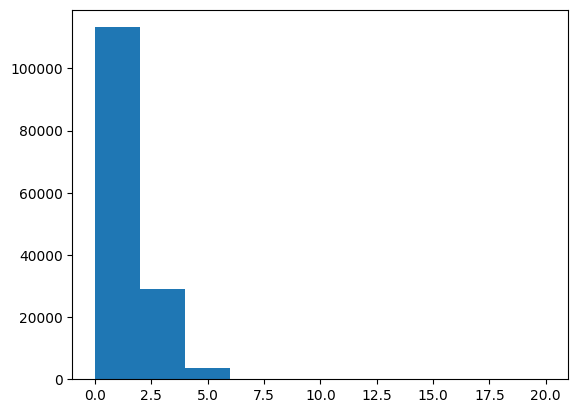

In [58]:
plt.hist(train_df["NumberOfDependents"])

(array([1.16924e+05, 2.92030e+04, 3.62800e+03, 2.09000e+02, 2.90000e+01,
        5.00000e+00, 1.00000e+00, 0.00000e+00, 0.00000e+00, 1.00000e+00]),
 array([ 0.,  2.,  4.,  6.,  8., 10., 12., 14., 16., 18., 20.]),
 <BarContainer object of 10 artists>)

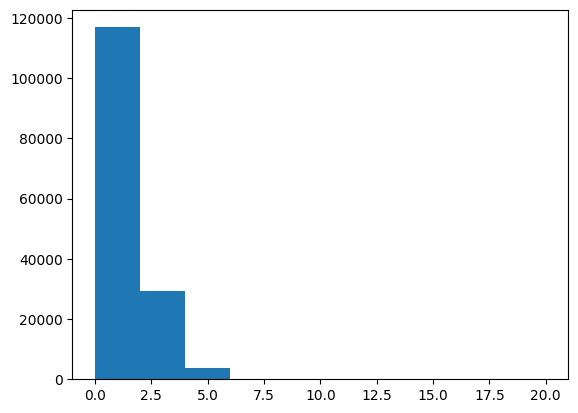

In [59]:
plt.hist(train_df_imputed["NumberOfDependents"])

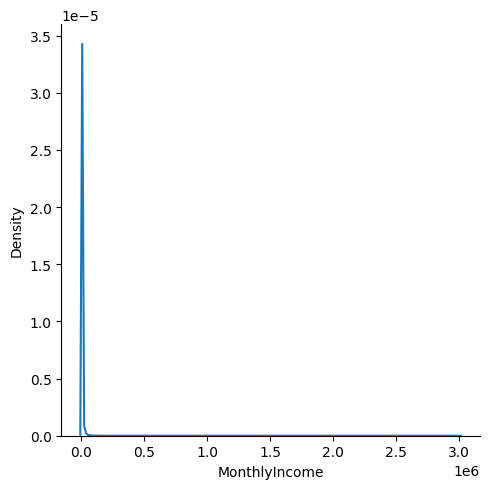

In [43]:
sns.displot(train_df, x = "MonthlyIncome", kind = "kde")

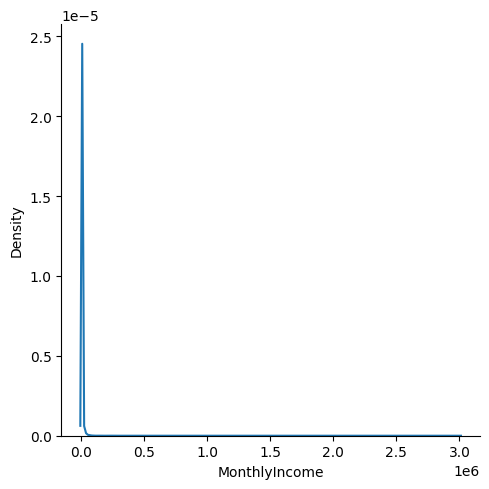

In [44]:
sns.displot(train_df_imputed, x = "MonthlyIncome", kind = "kde")

As seen above, there is no change in the distribution before and after imputation. This is good.

# Outlier removal

In [88]:
upper_arr = np.empty(0)
lower_arr = np.empty(0)
for i in train_df_imputed.columns:
    # use np.where and union all sets
    upper = np.where(train_df_imputed[i] >= st.mean(train_df_imputed[i]) + (3 * st.stdev(train_df_imputed[i])))
    lower = np.where(train_df_imputed[i] <= st.mean(train_df_imputed[i]) - (3 * st.stdev(train_df_imputed[i])))
    upper_arr = np.append(upper_arr, upper)
    lower_arr = np.append(lower_arr, lower)

drop_idx = np.unique(np.append(upper_arr, lower_arr))

train_no_outlier = train_df_imputed.drop(index = drop_idx)

In [89]:
train_no_outlier.info()


<class 'pandas.core.frame.DataFrame'>
Int64Index: 135150 entries, 1 to 149999
Data columns (total 11 columns):
 #   Column                                Non-Null Count   Dtype  
---  ------                                --------------   -----  
 0   SeriousDlqin2yrs                      135150 non-null  int64  
 1   RevolvingUtilizationOfUnsecuredLines  135150 non-null  float64
 2   age                                   135150 non-null  int64  
 3   NumberOfTime30-59DaysPastDueNotWorse  135150 non-null  int64  
 4   DebtRatio                             135150 non-null  float64
 5   MonthlyIncome                         135150 non-null  float64
 6   NumberOfOpenCreditLinesAndLoans       135150 non-null  int64  
 7   NumberOfTimes90DaysLate               135150 non-null  int64  
 8   NumberRealEstateLoansOrLines          135150 non-null  int64  
 9   NumberOfTime60-89DaysPastDueNotWorse  135150 non-null  int64  
 10  NumberOfDependents                    135150 non-null  float64
dtype